In [1]:
!pip3 install /Users/wenyun/Desktop/DSH/DSHpy_2024

Processing /Users/wenyun/Desktop/DSH/DSHpy_2024
  Preparing metadata (setup.py) ... done
  Created wheel for DSH: filename=DSH-1.0-py3-none-any.whl size=113124 sha256=a6edff8b56bfd820f658a25d73dc48604c8b3c22b568890ebfd962124f62886d
  Stored in directory: /private/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/pip-ephem-wheel-cache-yybkxieh/wheels/50/cf/c6/3fb987c904337737999b9dc00c0173ee55e48c84f0bdc6586b
Successfully built DSH
  Attempting uninstall: DSH
    Found existing installation: DSH 1.0
    Uninstalling DSH-1.0:
      Successfully uninstalled DSH-1.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import CorrMaps as CM
#import seaborn as sns
import pickle

In [3]:
def mask_heatmap(center,radius_out,heatmap):
    x_center=center[1]
    y_center=center[0]
    x = np.arange(heatmap.shape[0])
    y = np.arange(heatmap.shape[1])
    xv, yv = np.meshgrid(x,y)
    xv -= x_center
    yv -= y_center
    radius = np.sqrt(xv**2 + yv**2)
    mask=(radius<radius_out)
    heatmap_masked=heatmap*mask
    return heatmap_masked

<Kernel [2D Gauss], 9x9, s=(3.2;3.2)>


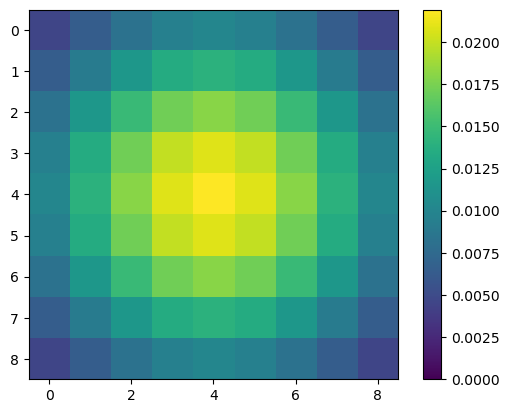

In [4]:
KernelSpecs = DSH.Kernel.Kernel()
KernelSpecs.Initialize(shape=(9,9), kernel_type='Gauss', params={'sigma':[3.2,3.2]}, padding=True)
print(KernelSpecs)
plt.imshow(KernelSpecs.ToMatrix(), vmin=0)
plt.colorbar()


|---------------|
| Config class: |
|---------------+---------------
| Section count : 1
| Total keys    : 5
| MIfile        : <5 keys>
|                 hdr_len = 0
|                 px_format = B
|                 fps = 1
|                 px_size = 1
|                 shape = [751, 389, 389]
|---------------+---------------


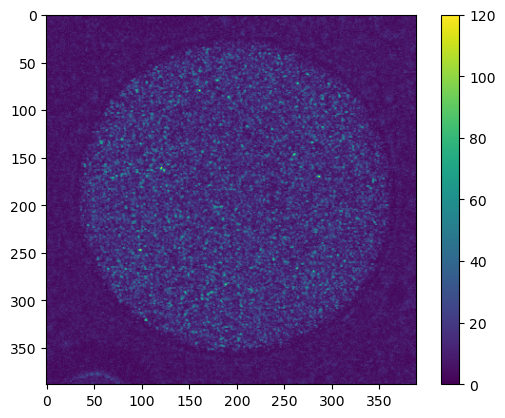

In [5]:
froot='/Volumes/T7red/silk_more/20240219/analysis/26min/'
fname = froot+'26min_derotate.raw'
metadata_fname = froot+'26min.ini'
mi_file = MI.MIfile(fname, metadata_fname)
mi_file.OpenForReading()
full_frame = mi_file.GetImage(0)
plt.imshow(full_frame)
plt.colorbar()
plt.grid(False)
print(mi_file.MetaData)

In [ ]:
test_ROI=[0,0,-1,-1]
KernelSpecs.SetPadding(False)
corrmap = CM.CorrMaps(mi_file, froot+'/chartime/', (np.arange(1,300,4)).tolist(), KernelSpecs, imgRange=[0,-1,1], cropROI=test_ROI)
cmap_list = corrmap.Compute(silent=False, return_maps=True)
with open(froot+'cmap_list.pkl', 'wb') as file:
    # Use pickle.dump() to serialize and save the list to the file
    pickle.dump(cmap_list, file)

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...
  STEP 2: Computing contrast...
  STEP 3: Computing correlations...
     ...lag 1
     ...lag 5
     ...lag 9
     ...lag 13
     ...lag 17
     ...lag 21
     ...lag 25
     ...lag 29
     ...lag 33
     ...lag 37
     ...lag 41
     ...lag 45
     ...lag 49
     ...lag 53
     ...lag 57
     ...lag 61
     ...lag 65
     ...lag 69
     ...lag 73
     ...lag 77
     ...lag 81
     ...lag 85
     ...lag 89
     ...lag 93
     ...lag 97
     ...lag 101
     ...lag 105
     ...lag 109
     ...lag 113
     ...lag 117
     ...lag 121
     ...lag 125
     ...lag 129
     ...lag 133
     ...lag 137
     ...lag 141
     ...lag 145
     ...lag 149
     ...lag 153
     ...lag 157
     ...lag 161
     ...lag 165
     ...lag 169
     ...lag 173
     ...lag 177
     ...lag 181
     ...lag 185
     ...lag 189
     ...lag 193
     ...lag 197
     ...lag 201
     ...lag 205
     ...lag 209
     ...lag 213
     ...

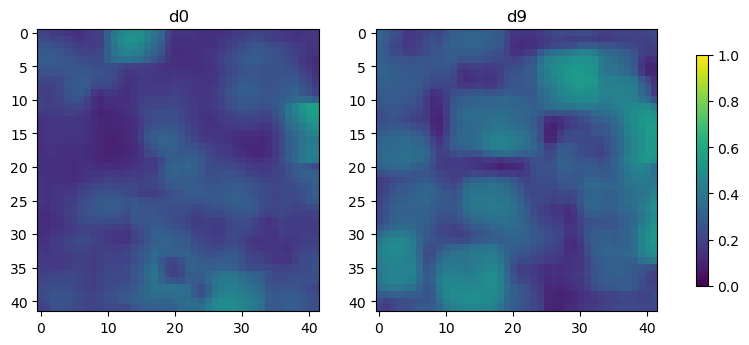

In [6]:
center=[191,195]
radius_outer=(319-9)#/2


with open(froot+'cmap_list.pkl', 'rb') as file:
    # Use pickle.load() to deserialize the pickled list
    cmap_list = pickle.load(file)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
tidx = 92
lagidx = 9
ax1.set_title('d0')
ax1.imshow(mask_heatmap(center,radius_outer,cmap_list[0][tidx]), vmin=0.0, vmax=1.0)
ax1.grid(False)
ax2.set_title('d'+str(lagidx))
cbar = ax2.imshow(mask_heatmap(center,radius_outer, np.mean(np.stack(cmap_list[lagidx][0:50]), axis=0)), vmin=0.0, vmax=1.0)
#cbar = ax2.imshow(mask_heatmap(center,radius_outer, cmap_list[lagidx][tidx]), vmin=0.0, vmax=1.0)
ax2.grid(False)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

In [8]:
corr_maps = CM.LoadFromConfig(os.path.join(froot, 'CorrMapsConfig.ini'), outFolder=froot)
print(corr_maps)


|-----------------|
| CorrMaps class: |
|-----------------+---------------
| MI input        : <MIfile: 0+751x389x389x1 bytes>
| output folder   : /Volumes/T7red/silk_more/20240219/analysis/26min/
| lag times (10)  : [1, 11, 21, 31, 41, 51, 61, 71, 81, 91]
| image range     : [0, 500, 1]
| crop ROI        : [150, 150, 50, 50]
| Kernel          : <Kernel [2D Gauss], 9x9, s=(3.2;3.2)>
|-----------------+---------------


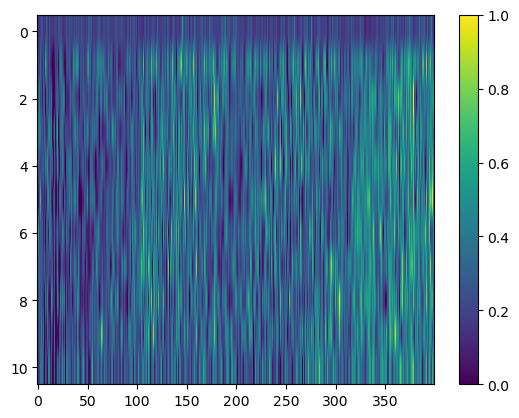

In [9]:
pxLoc = [30, 30]
load_tRange = [0,400,1]
cmap = corr_maps.GetCorrTimetrace(pxLoc, zRange=load_tRange)
cmap[np.where(cmap==0)]=np.nan
plt.imshow(cmap, aspect='auto', vmin=0, vmax=1)
plt.colorbar()

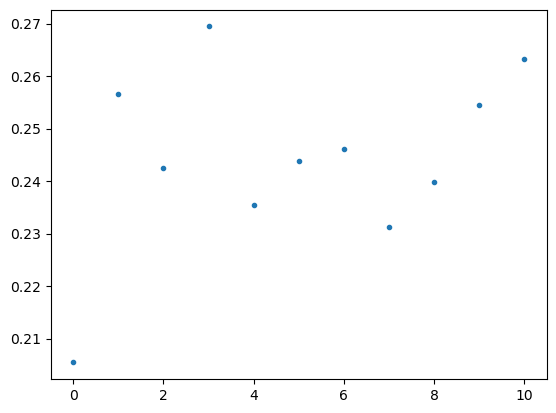

In [33]:
plt.plot(cmap[:,0:100].mean(axis=1),'.')

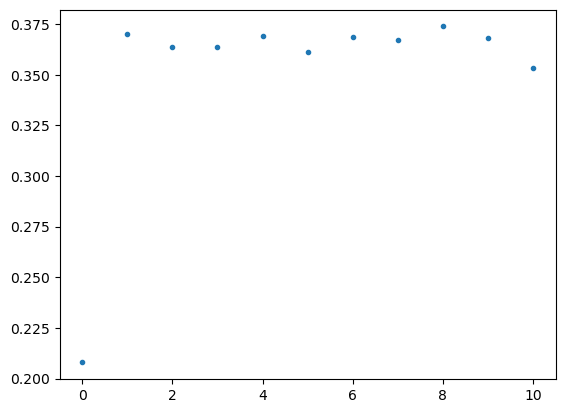

In [32]:
plt.plot(cmap[:,200:400].mean(axis=1),'.')